# Ultimate Data Challenge

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import classification_report
import math

In [2]:
logins = pd.read_json('logins.json')
retention = pd.read_json('ultimate_data_challenge.json')

## PART 1

I'll start by taking a look at the data

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.shape

(93142, 1)

In [5]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

We have one column that's a datetime object, as expected. Are there any missing values?

In [6]:
logins.isna().sum()

login_time    0
dtype: int64

No missing values. What's the range of time that this dataset covers?

In [7]:
logins.login_time.min()

Timestamp('1970-01-01 20:12:16')

In [8]:
logins.login_time.max()

Timestamp('1970-04-13 18:57:38')

About three and a half months. There doesn't seem to be any data quality issues with this set, so I'm now ready to aggregate the counts on fifteen minute intervals. To do this, I'll drop the date from the logins_date column, leaving only the time. Before that though, I'll round the column to the nearest 15 minutes

In [9]:
logins['login_time'] = logins['login_time'].dt.round('15min')

In [10]:
logins['login_time'] = logins['login_time'].dt.time

In [11]:
logins.sort_values('login_time', inplace = True)

In [12]:
logins_agg = logins.groupby('login_time')['login_time'].count()

In [13]:
logins_agg.head()

login_time
00:00:00    1497
00:15:00    1482
00:30:00    1503
00:45:00    1503
01:00:00    1509
Name: login_time, dtype: int64

In [14]:
counts = pd.DataFrame()

In [15]:
counts['Time'] = logins_agg.index

In [16]:
counts['counts'] = logins_agg.values

In [17]:
counts.head()

,Time,counts
0,00:00:00,1497
1,00:15:00,1482
2,00:30:00,1503
3,00:45:00,1503
4,01:00:00,1509


Great! Now we can start investigating based on these counts.

In [18]:
counts['counts'].describe()

count      96.000000
mean      970.229167
std       455.844306
min       178.000000
25%       678.000000
50%       922.500000
75%      1419.250000
max      1708.000000
Name: counts, dtype: float64

In [19]:
counts[counts['counts'] == 178]

,Time,counts
31,07:45:00,178


In [20]:
counts[counts['counts'] == 1708]

,Time,counts
90,22:30:00,1708


The morning seems to be the worst time for logins, and nighttime the best. Let's see a graph that takes us through the day.

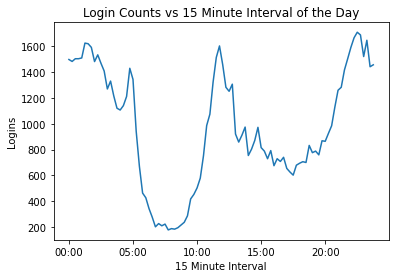

In [21]:
plt.plot(counts.index, counts['counts'])
plt.title('Login Counts vs 15 Minute Interval of the Day')
plt.xlabel('15 Minute Interval')
plt.ylabel('Logins')
plt.xticks(ticks = [0, 20, 40, 60, 80], labels = ['00:00', '05:00', '10:00', '15:00', '20:00'])
plt.show()

## PART 3

The retention dataframe will now be used to build a model that can be used to predict user retention at the 6-month mark.

In [22]:
retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [23]:
retention.shape

(50000, 12)

In [24]:
retention.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

A user is considered retained if there were active in the last 30 days. So we need to figure out when that time period ends.

In [25]:
retention['last_trip_date'].max()

'2014-07-01'

In [26]:
type(retention['last_trip_date'][0])

str

So, if a rider took a trip between June 1 and July 1, then they are considered retained.

In [27]:
retention['last_trip_date'] = pd.to_datetime(retention['last_trip_date'])
retention['signup_date'] = pd.to_datetime(retention['signup_date'])

In [28]:
retention['retained'] = retention['last_trip_date'].agg(
    lambda x: 0 if x < pd.to_datetime('2014-06-01') else 1)

In [29]:
retention['retained'].sum()

18804

In [30]:
retained_frac = 18804 / 50000
retained_frac

0.37608

About one-third of all signups from January 2014 were retained users. 

Now, to build a model that can predict retention. First, cleaning.

In [31]:
retention.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

Wow. Quite a lot of missing values from the avg_rating_of_driver column, around 20%. Phone and avg_rating_by_driver also have some missing values but not many. Let's look at these variables a little closer.

In [32]:
retention['avg_rating_of_driver'].value_counts()

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.7        2
1.8        2
1.9        1
1.6        1
2.2        1
Name: avg_rating_of_driver, dtype: int64

In [33]:
retention['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [34]:
retention['avg_rating_by_driver'].value_counts()

5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

For the ratings columns, 5.0 seems to be the overwhelming majority, and the average is expected to be quite high. For the phone column, iphone outweighs android by about 100%. I think filling the rating columns with the average values, but for the phone column this might not be as easy. I think dropping the rows missing phone data will be the best option, since there is about a 1/3 chance that the user is using an android and simply filling in iPhone could be just plain wrong.

In [35]:
retention['avg_rating_by_driver'].fillna(value = retention['avg_rating_by_driver'].mean(), inplace = True)
retention['avg_rating_of_driver'].fillna(value = retention['avg_rating_of_driver'].mean(), inplace = True)

In [36]:
retention.dropna(subset = 'phone', inplace = True)

In [37]:
retention.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
retained                  0
dtype: int64

I now want to look at the distributions of the variables to make sure that there are no values that do not make sense

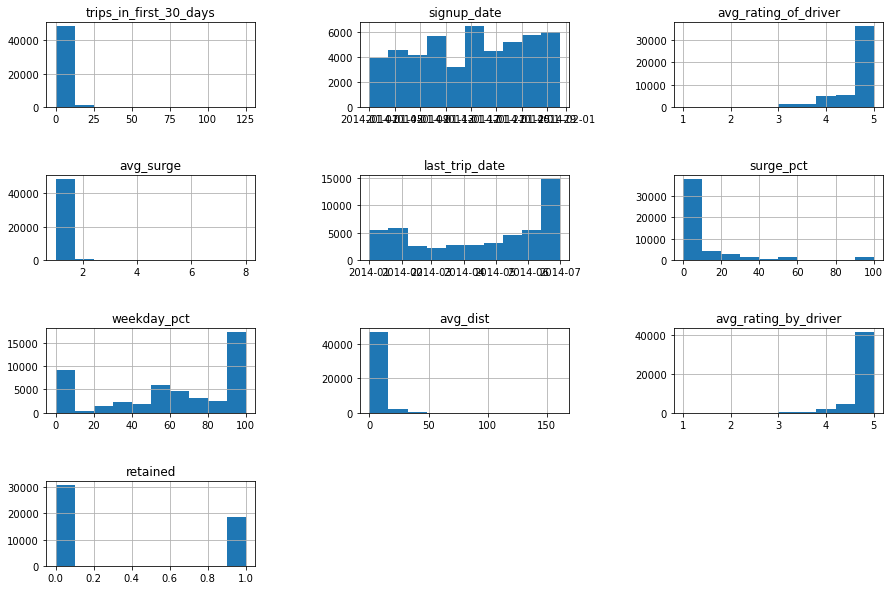

In [38]:
retention.hist(figsize = (15, 10))
plt.subplots_adjust(hspace=0.8, wspace = 0.5);

All seems correct there.

How many different cities are represented by the data?

In [39]:
retention['city'].value_counts()

Winterfell        23125
Astapor           16413
King's Landing    10066
Name: city, dtype: int64

Just three. How many Ultimate Black users were there?

In [40]:
retention['ultimate_black_user'].sum()

18612

Close to the same number that were retained. What is the average surge and surge for users that were retained vs users that weren't

In [41]:
retention[retention['retained'] == 0]['avg_surge'].mean()

1.0756887466459912

In [42]:
retention[retention['retained'] == 1]['avg_surge'].mean()

1.0738342884687653

Let's look at correlations.

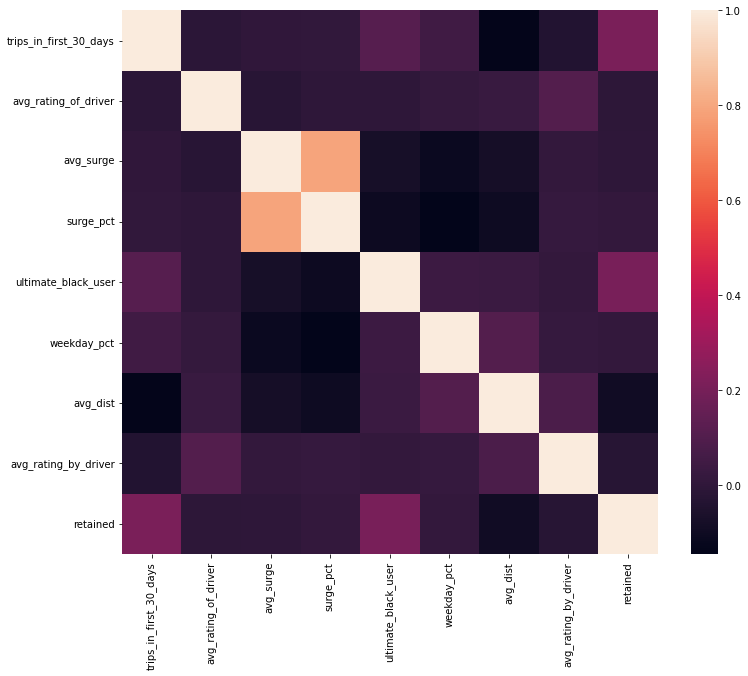

In [43]:
plt.subplots(figsize=(12,10))
sns.heatmap(retention.corr());

There appears to be very little auto-correlation in our data. I now want to try PCA with our float and int values and look at were the variance in our data is.

In [44]:
retention_scaled = scale(retention[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                                   'weekday_pct', 'avg_dist', 'avg_rating_by_driver']])

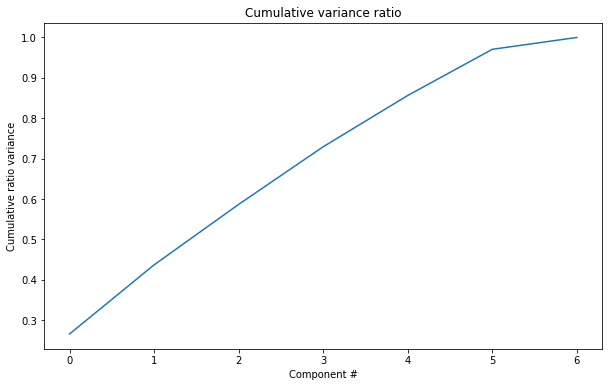

In [45]:
retention_pca = PCA().fit(retention_scaled)
plt.subplots(figsize=(10, 6))
plt.plot(retention_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio');

The variance is explained fairly evenly by all factors. I think now I will create dummy variables for the 'city' and 'phone' columns, split the data, and begin modeling.

In [46]:
retention_modeling = retention.drop(columns = ['signup_date', 'last_trip_date'])

In [47]:
retention_modeling = pd.get_dummies(retention_modeling, columns = ['city', 'phone'])

In [48]:
retention_modeling.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0


In [49]:
X_train, X_test, y_train, y_test = train_test_split(retention_modeling.drop(columns='retained'), 
                                                    retention_modeling.retained, test_size=0.3, 
                                                    random_state=47)

Before jumping into the model, I'll get a baseline performance using sklearns dummy classifier

In [50]:
dumb_class = DummyClassifier(strategy='most_frequent')
dumb_class.fit(X_train, y_train)
print(dumb_class.score(X_train, y_train))
y_pred = dumb_class.predict(X_train)
print(classification_report(y_pred, y_train))

0.6234951903692184
              precision    recall  f1-score   support

           0       1.00      0.62      0.77     34722
           1       0.00      0.00      0.00         0

    accuracy                           0.62     34722
   macro avg       0.50      0.31      0.38     34722
weighted avg       1.00      0.62      0.77     34722



Looks like our model needs to beat an accuracy of 62%. I'm choosing to go with a random forest classifier for my model. I've used it in the past so I am quite comfortable with it and I believe it is powerful enough to do this task with relatively low demand.

In [51]:
RF = RandomForestClassifier(random_state=47)
RF_pipe = make_pipeline(StandardScaler(), PCA(), RF)
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclass

In [52]:
n_components = range(5, 15)
n_estimators = range(10, 300, 10)
max_depth = range(3, 9)
grid_params = {'standardscaler': [StandardScaler(), MinMaxScaler()],
             'pca__n_components': n_components,
              'randomforestclassifier__n_estimators': n_estimators,
              'randomforestclassifier__max_depth': max_depth}
RF_cv = RandomizedSearchCV(RF_pipe, param_distributions = grid_params, n_iter = 100, cv = 5, n_jobs = -1, scoring = 'accuracy')

In [53]:
RF_cv.fit(X_train, y_train)
RF_cv.best_params_

{'standardscaler': MinMaxScaler(),
 'randomforestclassifier__n_estimators': 140,
 'randomforestclassifier__max_depth': 8,
 'pca__n_components': 13}

In [54]:
cv_results = cross_validate(RF_cv.best_estimator_, X_train, y_train, scoring='accuracy', cv=5)
RF_train_acc_mean = np.mean(-1 * cv_results['test_score'])
RF_train_acc_std = np.std(-1 * cv_results['test_score'])
print(RF_train_acc_mean, RF_train_acc_std)

-0.7756177736195851 0.0033450266122450993


In [55]:
Winning_model = make_pipeline(MinMaxScaler(), PCA(n_components = 11), 
                              RandomForestClassifier(n_estimators = 120, max_depth = 8))
Winning_model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=11)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, n_estimators=120))])

In [56]:
Winning_model['randomforestclassifier'].feature_importances_

array([0.16336285, 0.06477699, 0.13987523, 0.09367262, 0.16808964,
       0.08789639, 0.03536549, 0.19331056, 0.01584756, 0.01346812,
       0.02433456])

The features trips_in_first_30_days, avg_surge, ultimate_black_user, avg_rating_by_driver appear to be the most important to the model

In [57]:
print(classification_report(Winning_model.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     23317
           1       0.66      0.76      0.71     11405

    accuracy                           0.79     34722
   macro avg       0.77      0.78      0.77     34722
weighted avg       0.80      0.79      0.80     34722



In [58]:
print(classification_report(Winning_model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      9976
           1       0.63      0.72      0.67      4906

    accuracy                           0.77     14882
   macro avg       0.74      0.76      0.75     14882
weighted avg       0.78      0.77      0.77     14882



As you can see, this model performs much better than the dummy classifer used as a baseline.